In [131]:
# import libraries
from cryptography.fernet import Fernet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import copy
import warnings

In [2]:
# Loading the data
df = pd.read_csv('nutriboost_data.csv')
df.head()

,CustomerID,Age,Gender,Income_Level,Health_Conscious_Score,Current_Beverage_Preference,Purchase_Intention,Willingness_To_Pay,Feature_Preference_Taste,Feature_Preference_EnergyBoost,...,Expected_Repeat_Purchase_Rate,Open_Ended_Feedback,Preferred_Channel,Proximity_to_Store,Channel_Satisfaction,Awareness_Source,Promo_Response,Ad_Recall_Score,Coupon_Usage(%),Brand_Engagement
0,1,46,Male,Medium,8,Energy Drinks,0,83,1,3,...,0.85,Not sure if I would switch from my current brand.,Gym,1.27,2,Social Media,No,5,97,Medium
1,2,32,Male,High,6,NaN,1,129,5,3,...,0.55,Great taste but packaging could be improved.,Gym,3.41,5,Social Media,No,3,92,Medium
2,3,25,Female,Low,5,Water,1,43,4,5,...,0.43,Price is a concern for students like me.,Gym,3.80,4,TV,Yes,1,23,Low
3,4,38,Other,Low,6,Water,0,129,3,5,...,0.72,Not sure if I would switch from my current brand.,Convenience Store,2.98,1,Social Media,Yes,4,23,Medium
4,5,36,Other,Low,2,Juices,0,143,5,5,...,0.23,I love the idea of a healthy energy drink.,Cafe,2.36,3,Word of Mouth,No,5,3,Low


In [3]:
# Create the copy
df_copy = df.copy(deep = True)

In [4]:
# Replace the missing values with mode of the data
df_copy['Current_Beverage_Preference'] = df_copy['Current_Beverage_Preference'].fillna(df_copy['Current_Beverage_Preference'].mode()[0])

In [5]:
# Check for missing values
df_copy.isna().sum()

,0
CustomerID,0
Age,0
Gender,0
Income_Level,0
Health_Conscious_Score,0
Current_Beverage_Preference,0
Purchase_Intention,0
Willingness_To_Pay,0
Feature_Preference_Taste,0
Feature_Preference_EnergyBoost,0


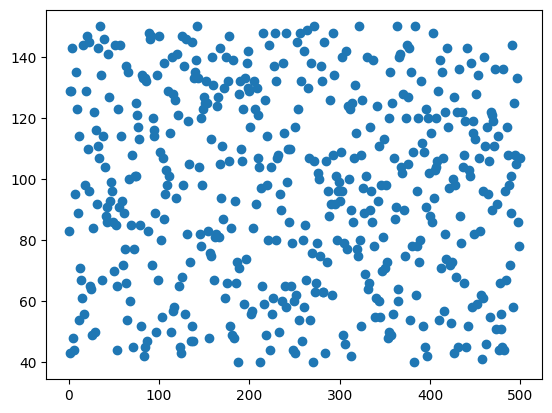

In [6]:
# See the Dependent Variable in Scatter Plot
plt.scatter(df_copy.index, df_copy['Willingness_To_Pay'])

In [7]:
# Independent and Dependent Variables
x = df_copy[['Age', 'Income_Level', 'Health_Conscious_Score', 'Feature_Preference_Taste',
       'Feature_Preference_EnergyBoost', 'Feature_Preference_Packaging',
       'Feature_Preference_Price', 'Feature_Preference_Availability']]
y = df_copy['Willingness_To_Pay']

In [8]:
# Separate categorical and numerical columns
categorical_col = ['Income_Level']
numerical_col = [col for col in x.columns if col not in categorical_col]

In [9]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_col),
        ('cat', OneHotEncoder(), categorical_col)
    ]
  )

In [10]:
# Building a Pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

In [125]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.64, random_state=42)

In [126]:
# Model fit
model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age',
                                                   'Health_Conscious_Score',
                                                   'Feature_Preference_Taste',
                                                   'Feature_Preference_EnergyBoost',
                                                   'Feature_Preference_Packaging',
                                                   'Feature_Preference_Price',
                                                   'Feature_Preference_Availability']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Income_Level'])])),
                ('regressor', LinearRegression())])

In [127]:
# Prediction
# -------------------------------
y_pred = model.predict(x_test)
predicted_price_regression = y_pred.mean()
print(f"\nPredicted Price (with Income_Level using OneHotEncoder): {predicted_price_regression:.2f}")


Predicted Price (with Income_Level using OneHotEncoder): 96.05


In [128]:
# Average Willingness to Price
mean_price = df_copy['Willingness_To_Pay'].mean()
round(mean_price,2)

np.float64(96.96)

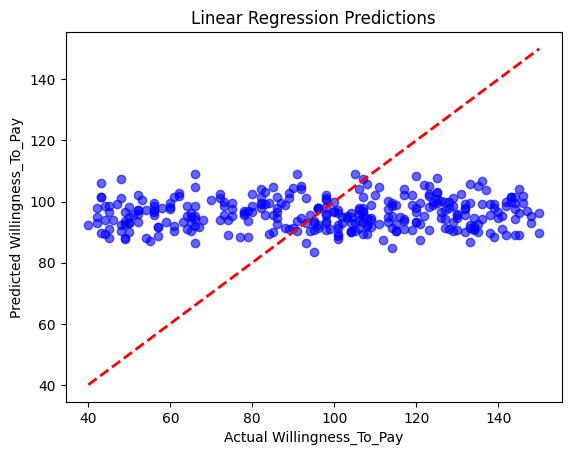

In [129]:
# Linear Regression Line
plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Willingness_To_Pay")
plt.ylabel("Predicted Willingness_To_Pay")
plt.title("Linear Regression Predictions")
plt.show()

In [ ]:
# Demand
demand =  df_copy.groupby('Willingness_To_Pay')['Purchase_Intention'].sum().sort_values(ascending = False).reset_index()
demand.head()

,Willingness_To_Pay,Purchase_Intention
0,148,7
1,44,6
2,67,6
3,80,6
4,98,6


In [ ]:
# Create Revenue column
demand['Revenue'] = demand['Willingness_To_Pay'] * demand['Purchase_Intention']
demand.head()

,Willingness_To_Pay,Purchase_Intention,Revenue
0,148,7,1036
1,44,6,264
2,67,6,402
3,80,6,480
4,98,6,588


In [ ]:
# Elasticity
elasticity = []

for i in range(1, len(demand)):
  q1,q2 = demand.loc[i-1, 'Purchase_Intention'], demand.loc[i, 'Purchase_Intention']
  p1,p2 = demand.loc[i-1, 'Willingness_To_Pay'], demand.loc[i, 'Willingness_To_Pay']
  dq = (q2 - q1) / q1 if q1 != 0 else 0
  dp = (p2 - p1) / p1 if p1 != 0 else 0
  Ed = (dq / dp) if dp != 0 else 0

elasticity.append({'Price': p2, 'Elasticity': Ed})

elasticity_df = pd.DataFrame(elasticity)


In [ ]:
# Optimal price (max revenue)
optimal_price_elasticity = demand.loc[demand["Revenue"].idxmax(), "Willingness_To_Pay"]
optimal_price_elasticity

np.int64(148)

In [ ]:
# Lowest Possible Price
min_wtp = int(df_copy["Willingness_To_Pay"].min())
max_wtp = int(df_copy["Willingness_To_Pay"].max())

In [ ]:
# Price
prices = np.arange(min_wtp, max_wtp+1, 1)
revenue = []

for p in prices:
  buyers = df_copy[df_copy['Willingness_To_Pay'] >= p].shape[0]
  revenues = p * buyers
  revenue.append(revenues)

lowest_price = prices[np.argmax(revenue)]

print("To sustain in the competition we can keep the pricing at:", lowest_price)

To sustain in the competition we can keep the pricing at: 78
